In [2]:
import tensorflow as tf
from keras.layers import TFSMLayer
from keras import Model, Input

# Path to your converted SavedModel
path = "/kaggle/input/xception/converted_xception_savedmodel"

# Load SavedModel as a Keras-compatible layer
xception_layer = TFSMLayer(path, call_endpoint="serving_default")

# Rewrap it as a model (so you can call model.predict etc.)
inp = Input(shape=(299, 299, 3))  # Xception input shape
out = xception_layer(inp)
model = Model(inputs=inp, outputs=out)

# Test
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tfsm_layer_1 (TFSMLayer)        │ (None, 1)              │    21,386,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,386,281 (81.58 MB)

 Trainable params: 21,331,753 (81.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [3]:
# ===============================
# 1️⃣ Import Libraries
# ===============================
import os, gc, cv2, random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.layers import TFSMLayer
from keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf


In [4]:
# ===============================
# 2️⃣ Load Pretrained Models
# ===============================
# Xception (SavedModel format — Keras 3 compatible)
xception_layer = TFSMLayer("/kaggle/input/xception/converted_xception_savedmodel",
                           call_endpoint="serving_default")
xception_model = Sequential([xception_layer])

# EfficientNetB3 (.keras format)
efficientnet_model = load_model("/kaggle/input/efficientnetb3/deepfake_efficientnet_b3_best.keras")

print("✅ Both models loaded successfully!")


✅ Both models loaded successfully!


In [5]:
# ===============================
# 3️⃣ Dataset Paths (140k Dataset)
# ===============================
BASE_PATH = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train"
REAL_PATH = os.path.join(BASE_PATH, "real")
FAKE_PATH = os.path.join(BASE_PATH, "fake")

print("📂 Using data from:")
print("Real:", REAL_PATH)
print("Fake:", FAKE_PATH)


📂 Using data from:
Real: /kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train/real
Fake: /kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train/fake


In [6]:
# ===============================
# 4️⃣ FFT Preprocessing Function
# ===============================
def apply_fft(img_path, img_size=299):
    try:
        img = load_img(img_path, target_size=(img_size, img_size))
        img = img_to_array(img)
        gray = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2GRAY)
        f = np.fft.fft2(gray)
        fshift = np.fft.fftshift(f)
        magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)
        mag_img = cv2.normalize(magnitude_spectrum, None, 0, 255, cv2.NORM_MINMAX)
        mag_img = np.stack((mag_img,)*3, axis=-1)
        return mag_img / 255.0
    except:
        return None


In [9]:
# ===============================
# 5️⃣ Batch FFT Prediction Function (FIXED)
# ===============================
def batch_fft_predict(model, folder_path, img_size, label, batch_size=50):
    preds, labels = [], []
    files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    random.shuffle(files)
    
    for i in tqdm(range(0, len(files), batch_size)):
        batch_files = files[i:i+batch_size]
        batch_imgs = []
        for file in batch_files:
            img_path = os.path.join(folder_path, file)
            with tf.device('/CPU:0'):  # force FFT on CPU to reduce GPU load
                fft_img = apply_fft(img_path, img_size)
            if fft_img is not None:
                batch_imgs.append(fft_img)

        if batch_imgs:
            X_batch = np.array(batch_imgs)
            pred_batch = model.predict(X_batch, verbose=0)

            # ✅ Handle dict output (for TFSMLayer-based models like Xception)
            if isinstance(pred_batch, dict):
                pred_values = list(pred_batch.values())[0]  # Extract first tensor
            else:
                pred_values = pred_batch

            preds.extend(pred_values.flatten())
            labels.extend([label] * len(pred_values))

        # 🧹 Free memory after every batch
        del batch_imgs, X_batch, pred_batch
        gc.collect()

    return np.array(preds), np.array(labels)


In [10]:
# ===============================
# 6️⃣ Generate Predictions in Batches (Fixed)
# ===============================

# --- Xception (TFSMLayer) ---
print("🎯 Generating Xception FFT predictions...")
xcp_real_preds, y_real_real = batch_fft_predict(xception_model, REAL_PATH, 299, 1)
xcp_fake_preds, y_fake_fake = batch_fft_predict(xception_model, FAKE_PATH, 299, 0)

# Combine Xception predictions and labels
xception_preds = np.concatenate([xcp_real_preds, xcp_fake_preds])
y_xcp = np.concatenate([y_real_real, y_fake_fake])
print(f"✅ Xception predictions ready — total: {len(xception_preds)}")

# --- EfficientNetB3 (.keras) ---
print("🎯 Generating EfficientNetB3 FFT predictions...")
eff_real_preds, y_real_eff = batch_fft_predict(efficientnet_model, REAL_PATH, 300, 1)
eff_fake_preds, y_fake_eff = batch_fft_predict(efficientnet_model, FAKE_PATH, 300, 0)

# Combine EfficientNetB3 predictions and labels
efficientnet_preds = np.concatenate([eff_real_preds, eff_fake_preds])
y_eff = np.concatenate([y_real_eff, y_fake_eff])
print(f"✅ EfficientNetB3 predictions ready — total: {len(efficientnet_preds)}")

# --- Safety Check: Same label order ---
if not np.array_equal(y_xcp, y_eff):
    print("⚠️ Warning: Label arrays differ! Aligning automatically...")
    min_len = min(len(y_xcp), len(y_eff))
    y_xcp, y_eff = y_xcp[:min_len], y_eff[:min_len]
    xception_preds, efficientnet_preds = xception_preds[:min_len], efficientnet_preds[:min_len]

# --- Combine into Meta Features ---
meta_features_fft = np.column_stack([xception_preds, efficientnet_preds])
meta_labels = y_xcp  # same order

meta_fft_df = pd.DataFrame({
    "Xception_FFT_Prob": xception_preds,
    "EfficientNetB3_FFT_Prob": efficientnet_preds,
    "Label": meta_labels
})

# --- Save Results ---
meta_fft_df.to_csv("meta_training_fft.csv", index=False)
print(f"✅ Saved meta_training_fft.csv successfully with shape: {meta_fft_df.shape}")


🎯 Generating Xception FFT predictions...


100%|██████████| 1000/1000 [30:26<00:00,  1.83s/it]


✅ Xception predictions ready — total: 100000
🎯 Generating EfficientNetB3 FFT predictions...


100%|██████████| 1000/1000 [20:39<00:00,  1.24s/it]


✅ EfficientNetB3 predictions ready — total: 100000
✅ Saved meta_training_fft.csv successfully with shape: (100000, 3)


In [15]:
def get_gradcam_heatmap(model, img_array, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # ✅ Fix: convert safely to numpy if needed
    if isinstance(heatmap, tf.Tensor):
        heatmap = heatmap.numpy()

    # Normalize for visualization
    heatmap = np.maximum(heatmap, 0)
    if np.max(heatmap) != 0:
        heatmap /= np.max(heatmap)

    return heatmap


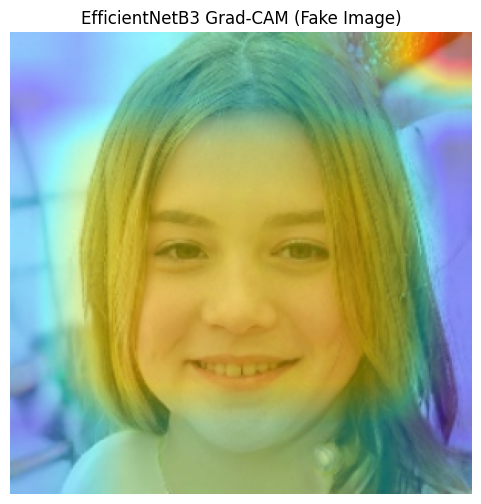

In [18]:
test_img_path = os.path.join(FAKE_PATH, random.choice(os.listdir(FAKE_PATH)))

img_eff = load_img(test_img_path, target_size=(300, 300))
img_eff_array = np.expand_dims(img_to_array(img_eff)/255.0, axis=0)

heatmap_eff = get_gradcam_heatmap(efficientnet_model, img_eff_array, "top_conv")

orig_img = cv2.cvtColor(cv2.imread(test_img_path), cv2.COLOR_BGR2RGB)
overlay_eff = overlay_heatmap(heatmap_eff, cv2.resize(orig_img, (300, 300)))

plt.figure(figsize=(6,6))
plt.imshow(overlay_eff)
plt.title("EfficientNetB3 Grad-CAM (Fake Image)")
plt.axis("off")
plt.show()


In [19]:
from tensorflow.keras.applications import Xception

# Load a fresh Keras version of Xception for Grad-CAM visualization
xcp_vis_model = Xception(weights='imagenet', include_top=True)


91884032/91884032 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


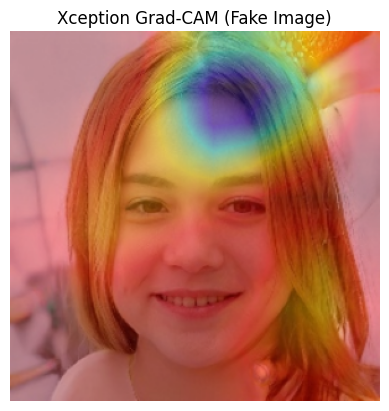

In [23]:
img_xcp = load_img(test_img_path, target_size=(299, 299))
img_xcp_array = np.expand_dims(img_to_array(img_xcp)/255.0, axis=0)

heatmap_xcp = get_gradcam_heatmap(xcp_vis_model, img_xcp_array, "block14_sepconv2_act")

overlay_xcp = overlay_heatmap(heatmap_xcp, cv2.resize(orig_img, (299, 299)))
plt.imshow(overlay_xcp)
plt.title("Xception Grad-CAM (Fake Image)")
plt.axis('off')
plt.show()
